https://cdn.aaai.org/ojs/10295/10295-13-13823-1-2-20201228.pdf

In [1]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt
import random
from collections import deque

In [2]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 512)
        self.bn1 = nn.LayerNorm(512)  # Add BatchNorm layer
        self.dropout1 = nn.Dropout(0.2)  # Add dropout after first layer
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.LayerNorm(512)  # Add BatchNorm layer
        self.dropout2 = nn.Dropout(0.2)  # Add dropout after second layer
        self.fc3 = nn.Linear(512, n_actions)

        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.leaky_relu(self.bn1(self.fc1(state)), negative_slope=0.01)
        layer1 = self.dropout1(layer1)
        layer2 = F.leaky_relu(self.bn2(self.fc2(layer1)), negative_slope=0.01)
        layer2 = self.dropout2(layer2)
        actions = self.fc3(layer2)
        return actions

In [3]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99, epsilon=1.0, ep_dec=1e-5, ep_min=0.01, mem_size=100000, batch_size=200):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = ep_dec
        self.eps_min = ep_min
        self.n_action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.memory = deque(maxlen=mem_size)

        self.Q1 = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)
        self.Q2 = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.append((state, action, reward, state_, done))

    def sample_memory(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, states_, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(states_), np.array(dones)

    def choose_action(self, observation):
        self.Q1.eval()
        self.Q2.eval()
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float32).to(self.Q1.device)
            actions_q1 = self.Q1.forward(state)
            actions_q2 = self.Q2.forward(state)
            actions = actions_q1 + actions_q2
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.n_action_space)
        self.Q1.train()
        self.Q2.train()
        return action
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        self.Q1.optimizer.zero_grad()
        self.Q2.optimizer.zero_grad()
        states, actions, rewards, states_, dones = self.sample_memory()

        states = T.tensor(states, dtype=T.float32).to(self.Q1.device)
        actions = T.tensor(actions, dtype=T.long).to(self.Q1.device)
        rewards = T.tensor(rewards, dtype=T.float32).to(self.Q1.device)
        states_ = T.tensor(states_, dtype=T.float32).to(self.Q1.device)
        dones = T.tensor(dones, dtype=T.bool).to(self.Q1.device)

        batch_indices = np.arange(self.batch_size, dtype=np.int64)

        q1_pred = self.Q1.forward(states)[batch_indices, actions]
        q2_pred = self.Q2.forward(states)[batch_indices, actions]

        # 计算下一步 max Q 的值，由于不希望更新下一步的 Q 值，所以使用 no_grad  
        with T.no_grad():
            q1_next = self.Q1.forward(states_)
            q2_next = self.Q2.forward(states_)
            q1_next[dones] = 0.0
            q2_next[dones] = 0.0

            q_target = rewards + self.gamma * T.min(q1_next, q2_next).max(dim=1)[0]

        loss_q1 = self.Q1.loss(q_target, q1_pred).to(self.Q1.device)
        loss_q2 = self.Q2.loss(q_target, q2_pred).to(self.Q2.device)
        loss = (loss_q1 + loss_q2) / 2

        loss.backward()
        self.Q1.optimizer.step()
        self.Q2.optimizer.step()
        self.decrement_epsilon()

In [4]:
def plot_learning_curve(x, scores, eps_history, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, eps_history, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis="x", colors="C0")
    ax.tick_params(axis="y", colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color="C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis="y", colors="C1")

    # plt.savefig(filename)
    return plt

In [5]:
env = gym.make('CartPole-v1')

In [6]:
env.action_space.n

2

In [7]:
env = gym.make('CartPole-v1')
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
n_games = 50000
scores = []
eps_history = []

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()[0]

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, terminated, truncated, info = env.step(action)
        score += reward
        agent.store_transition(obs, action, reward, obs_, terminated or truncated)
        agent.learn()
        obs = obs_
        done = terminated or truncated

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        if i % 1000 == 0:
            print(f'episode {i} score {score} average score {avg_score} epsilon {agent.epsilon}')

c:\Users\pangruitao\.conda\envs\py310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0 score 13.0 average score 13.0 epsilon 1.0
episode 1000 score 28.0 average score 38.49 epsilon 0.7077900000013299
episode 2000 score 500.0 average score 407.52 epsilon 0.01
episode 3000 score 10.0 average score 9.38 epsilon 0.01
episode 4000 score 500.0 average score 500.0 epsilon 0.01
episode 5000 score 9.0 average score 9.25 epsilon 0.01
episode 6000 score 500.0 average score 488.69 epsilon 0.01
episode 7000 score 9.0 average score 9.58 epsilon 0.01
episode 8000 score 13.0 average score 210.63 epsilon 0.01
episode 9000 score 35.0 average score 28.99 epsilon 0.01
episode 10000 score 500.0 average score 500.0 epsilon 0.01
episode 11000 score 10.0 average score 9.29 epsilon 0.01
episode 12000 score 8.0 average score 9.47 epsilon 0.01
episode 13000 score 500.0 average score 372.71 epsilon 0.01
episode 14000 score 9.0 average score 21.11 epsilon 0.01
episode 15000 score 10.0 average score 18.26 epsilon 0.01
episode 16000 score 9.0 average score 10.31 epsilon 0.01
episode 17000 sc

<module 'matplotlib.pyplot' from 'c:\\Users\\pangruitao\\.conda\\envs\\py310\\lib\\site-packages\\matplotlib\\pyplot.py'>

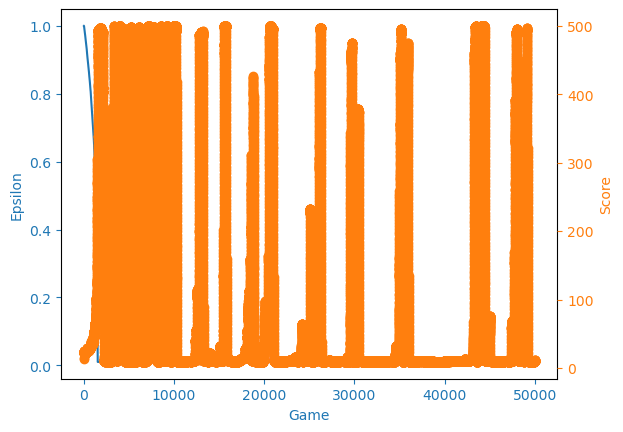

In [8]:
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)